# 11/13/19

Got the LMCL model working to some degree on high-dimensional data. However, there was some issue that caused a NaN loss halfway through model training. I might just drop this endeavor and continue onto greener pastures i.e. data slicing or mutual information maximization.

In [7]:
%load_ext autoreload
%autoreload 2

import os
os.chdir('/lfs/1/gangus/repositories/pytorch-classification')

import os.path as osp
import json
import pickle

import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

import models.cifar as models
from analysis.analysis_utils import load_trained_model, fetch_dataloaders, get_coarse_accuracies

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
experiment_paths = {
    'baseline': 'experiments/CIFAR100/superclass/baseline/1',
    'lmcl': 'experiments/CIFAR100/superclass/lmcl/1'
}

experiment_configs = {}
for exp_name, exp_path in experiment_paths.items():
    with open(osp.join(exp_path, 'config.json')) as f:
        experiment_configs[exp_name] = json.load(f)

In [13]:
config = experiment_configs['baseline']

superclass = config['superclass']
cifar_type = config['cifar_type']
model_name = config['model_name']
model_args = config['model_args']
checkpoint_dir = config['checkpoint_dir']
trained_model = load_trained_model(cifar_type, model_name, model_args, checkpoint_dir)

data_dir = config['data_dir']
dataset_configs = config['dataset_configs']
dataloader_configs = config['dataloader_configs']
dataloaders = fetch_dataloaders(data_dir, cifar_type, superclass, dataset_configs, dataloader_configs)

# Getting class-to-index maps for CIFAR100
class_to_idx = {}
class_to_idx['super'] = dataloaders['test'].dataset.class_to_idx
class_to_idx['sub'] = dataloaders['test'].dataset.fine_class_to_idx

idx_to_class = {}
for tp in ['super', 'sub']:
    idx_to_class[tp] = {v:k for k, v in class_to_idx[tp].items()}
    
trained_model = trained_model.to('cpu')
trained_model = trained_model.module.to('cpu')

Using 20 classes...
Using coarse labels...
Using coarse labels...


In [14]:
filenames_all = []
coarse_labels_all = []
fine_labels_all = []
fine_preds_all = []
preds_all = []
losses_all = []
softmax_all = []
features_all = []

t = tqdm(total=len(dataloaders['test']))
for batch_idx, (inputs, 
                targets, 
                coarse_labels, 
                fine_labels, 
                filenames) in enumerate(dataloaders['test']):
    
    inputs, targets = inputs.cpu(), targets.cpu()
    inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)
    
    outputs = trained_model(inputs)
    _, preds = outputs.topk(1, 1, True, True)
    soft = torch.nn.Softmax(dim=-1)(outputs)
    # feats = extract_resnext_features(trained_model,inputs)
    
    coarse_labels_all+=list([int(a) for a in coarse_labels])
    fine_labels_all+=list([int(a) for a in fine_labels])
    preds_all+=list([int(a) for a in preds])
    softmax_all+=list([a.detach().cpu().numpy() for a in soft])
    # features_all+=list([a.detach().cpu().numpy() for a in feats])
    filenames_all+=list(filenames)
    t.update()
t.close()


100%|██████████| 100/100 [02:01<00:00,  1.22s/it]


In [15]:
preds_dict = {
    'filename':filenames_all,
    'fine_labels':fine_labels_all,
    'coarse_labels':coarse_labels_all,
    'preds':preds_all,
    'fine_labels_string': [idx_to_class['sub'][a] for a in fine_labels_all],
    'coarse_labels_string': [idx_to_class['super'][a] for a in coarse_labels_all],
    # 'features':features_all,
    'softmax':softmax_all,
}
with open(f"{checkpoint_dir}/predictions.pkl",'wb') as f:
   pickle.dump(preds_dict, f)

prediction_df = pd.DataFrame(preds_dict)

In [16]:
coarse_results = get_coarse_accuracies(prediction_df)

coarse label accuracy: 0.872 	 (superclass: large_natural_outdoor_scenes)
--
coarse label accuracy: 0.82	 (subclass: mountain)
coarse label accuracy: 0.76	 (subclass: forest)
coarse label accuracy: 0.94	 (subclass: sea)
coarse label accuracy: 0.89	 (subclass: cloud)
coarse label accuracy: 0.95	 (subclass: plain)
==

coarse label accuracy: 0.648 	 (superclass: aquatic_mammals)
--
coarse label accuracy: 0.6	 (subclass: seal)
coarse label accuracy: 0.54	 (subclass: beaver)
coarse label accuracy: 0.73	 (subclass: whale)
coarse label accuracy: 0.77	 (subclass: dolphin)
coarse label accuracy: 0.6	 (subclass: otter)
==

coarse label accuracy: 0.83 	 (superclass: fruit_and_vegetables)
--
coarse label accuracy: 0.74	 (subclass: mushroom)
coarse label accuracy: 0.96	 (subclass: apple)
coarse label accuracy: 0.92	 (subclass: orange)
coarse label accuracy: 0.8	 (subclass: pear)
coarse label accuracy: 0.73	 (subclass: sweet_pepper)
==

coarse label accuracy: 0.88 	 (superclass: flowers)
--
coarse l

In [17]:
# Melting dataframe for plotting
plot_df = pd.DataFrame(coarse_results).reset_index()
plot_df = plot_df.rename(columns={"index": "Superclass"})
plot_df = plot_df.melt(id_vars=['Superclass'], var_name='Subset', value_name='Accuracy')

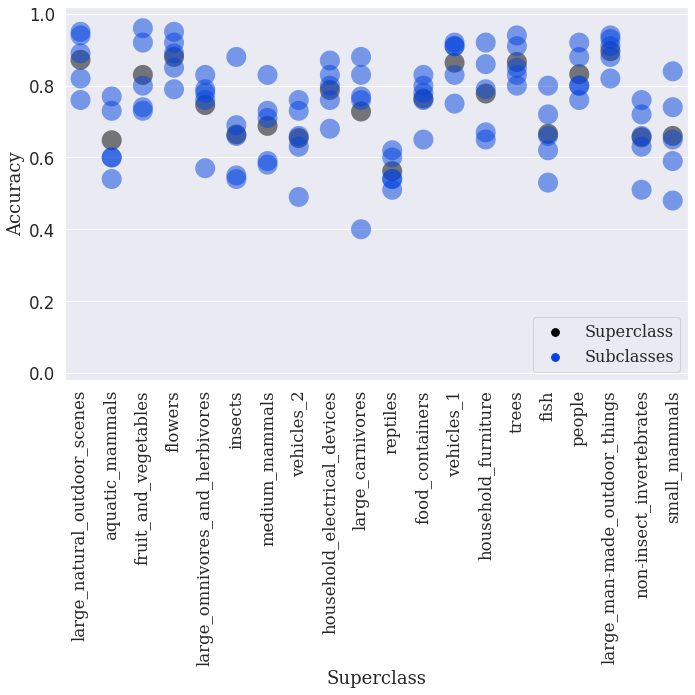

In [18]:
sns.set(font_scale=1.2) 
sns.set_style("whitegrid")
sns.set_style({'font.family':'serif'})

font = font_manager.FontProperties(family='Dejavu Serif',
                                   style='normal', size=16)
plt.rcParams.update({'font.family': 'serif'})

palette = [sns.xkcd_rgb["black"]] + 5*[sns.xkcd_rgb["blue"]]
sns.set(font_scale=1.5)
f = plt.figure(figsize=(10,10))
ax = sns.stripplot(x="Superclass", y="Accuracy", hue="Subset", data=plot_df, jitter=False, s=20, palette=palette, alpha=0.5)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90,fontdict={'family':'Dejavu Serif'})
# ax.set_yticklabels(ax.get_yticklabels(),fontdict={'family':'Dejavu Serif'})
ax.set_xlabel(ax.get_xlabel(),fontdict={'family':'Dejavu Serif'})
ax.set_ylabel(ax.get_ylabel(),fontdict={'family':'Dejavu Serif'})
h,l = ax.get_legend_handles_labels()
l[1] = 'Subclasses'
l[0] = 'Superclass'
ax.legend_.remove()
ax.legend(h[0:2],l[0:2], ncol=1, loc='lower right',prop=font)
ax.set_ylim([-0.02,1.02])
plt.tight_layout()
plt.savefig(f'{checkpoint_dir}/Superclass-Subclass-CIFAR-100-Correct-Val-v3.png',format='png')
plt.show()